In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load les datas dans le dossier Data B2 en créant une datafram pour chaque fichier excel:
bench_ligne=pd.read_csv('raw/bench_lignes.csv',)
caracteristique_part=pd.read_csv('raw/caracteristiques_parts.csv')
fixing=pd.read_csv('raw/fixing.csv')
frais=pd.read_csv('raw/frais.csv')
taux_historique=pd.read_csv('raw/historique_taux.csv')
passif_annee_2=pd.read_csv('raw/passif_annee_2_albert_school.csv')
perf_bench=pd.read_csv('raw/perf_bench.csv')
perf_fond=pd.read_csv('raw/perf_fonds.csv')
position_euro_high_yield=pd.read_csv('raw/positions_eurohighyield.csv')
usgg10_year_index=pd.read_csv('raw/usgg10yr_index.csv')
passif_yield=pd.read_csv('processed/passif_yield.csv')
bench_yield=pd.read_csv('processed/bench_yield.csv')
caracteristique_yield=pd.read_csv('processed/caracteristique_yield.csv')

/var/folders/bv/5rwcdyf13z576lffnd4q0ym40000gn/T/ipykernel_38447/1296204112.py:10: DtypeWarning: Columns (0,1,2,4,5,6,7,8,9,16) have mixed types. Specify dtype option on import or set low_memory=False.
  position_euro_high_yield=pd.read_csv('raw/positions_eurohighyield.csv')


In [3]:
# Vérification des types de colonnes
print(passif_yield.dtypes)

# Convertir les colonnes en types appropriés
passif_yield['Net Inflows MTD (€)'] = pd.to_numeric(passif_yield['Net Inflows MTD (€)'], errors='coerce')
passif_yield['Net Inflows YTD (€)'] = pd.to_numeric(passif_yield['Net Inflows YTD (€)'], errors='coerce')
passif_yield['AUM (€)'] = pd.to_numeric(passif_yield['AUM (€)'], errors='coerce')
passif_yield['Date'] = pd.to_datetime(passif_yield['Date'], errors='coerce')

# Vérification des valeurs manquantes
print(passif_yield.isnull().sum())

Unnamed: 0                                                                           int64
Owner                                                                               object
Business Relationship                                                               object
Fund                                                                                object
Share                                                                               object
Share Type                                                                          object
ISIN                                                                                object
Date                                                                                object
AUM (€)                                                                            float64
Quantity                                                                             int64
Net Inflows YTD (€)                                                                  int64

In [4]:
# Suppression des lignes avec des dates ou flux manquants
passif_yield_cleaned = passif_yield.dropna(subset=['Date', 'Net Inflows MTD (€)', 'Net Inflows YTD (€)'])

In [5]:
# Ajouter des colonnes 'Year', 'Quarter', et 'Semester'
passif_yield_cleaned['Year'] = passif_yield_cleaned['Date'].dt.year
passif_yield_cleaned['Quarter'] = passif_yield_cleaned['Date'].dt.to_period('Q')
passif_yield_cleaned['Semester'] = passif_yield_cleaned['Date'].dt.to_period('6M')

In [6]:
# Créer une fonction pour catégoriser les segments
def categorize_segment(segment):
    if 'Bank' in segment:
        return 'Bank'
    elif 'Insurance' in segment:
        return 'Insurance'
    elif 'AM company' in segment:
        return 'AM company'
    elif 'Pension Fund' in segment:
        return 'Pension Fund'
    elif 'Financial Advisor' in segment:
        return 'Financial Advisor'
    elif 'Single Family Office' in segment:
        return 'Single Family Office'
    elif 'Consultant' in segment:
        return 'Consultant'
    else:
        return 'Other'

# Appliquer la fonction à la colonne BR Segmentation
passif_yield_cleaned['Segment_Type'] = passif_yield_cleaned['BR Segmentation (Business Relationship) (Business Relationship)'].apply(categorize_segment)

# Vérifier les nouvelles catégories
print(passif_yield_cleaned['Segment_Type'].value_counts())

Segment_Type
Bank                    4837
Insurance               1541
AM company              1103
Financial Advisor        271
Other                    167
Pension Fund              48
Single Family Office      39
Consultant                 4
Name: count, dtype: int64


In [7]:
# Extraire la devise (partie après le dernier tiret)
passif_yield_cleaned['Currency'] = passif_yield_cleaned['Share'].str.extract(r'- (\w+)$')

# Vérifier les nouvelles colonnes créées
print(passif_yield_cleaned[['Share', 'Share Type', 'Currency']].head())

                              Share Share Type Currency
0  EdR Fund Euro High Yield A - EUR          A      EUR
1  EdR Fund Euro High Yield A - EUR          A      EUR
2  EdR Fund Euro High Yield A - EUR          A      EUR
3  EdR Fund Euro High Yield A - EUR          A      EUR
4  EdR Fund Euro High Yield I - EUR          I      EUR


In [8]:
# Créer la colonne Profile
passif_yield_cleaned['Profile'] = passif_yield_cleaned['Share Type'] + ' - ' + passif_yield_cleaned['Currency']

# Vérifier les valeurs uniques
print(passif_yield_cleaned['Profile'].unique())

['A - EUR' 'I - EUR' 'R - EUR' 'B - EUR' 'J - EUR' nan 'CR - EUR'
 'O - EUR' 'K - EUR' 'N - EUR' 'A - CHF']


In [9]:
# Grouper les données par critères clés de segmentation
segmentation_clients = (
    passif_yield_cleaned.groupby([
        'Segment_Type',          # Typologie des clients
        'Share Type',               # Type de part
        'Currency',                 # Devise
        'Profile',                  # Profil combiné
        'Business Country (Business Relationship) (Business Relationship)'  # Pays d'origine
        ,'Date',
        'Year', 'Quarter', 'Semester'  # Informations temporelles
    ])[['Net Inflows MTD (€)', 'Net Inflows YTD (€)', 'AUM (€)']]  # Variables financières
    .sum()  # Somme des valeurs pour chaque segment
    .reset_index()
    .sort_values(by='Net Inflows MTD (€)', ascending=False)  # Trier par flux nets MTD
)


segmentation_clients.head(10) # Afficher les 10 premières lignes

,Segment_Type,Share Type,Currency,Profile,Business Country (Business Relationship) (Business Relationship),Date,Year,Quarter,Semester,Net Inflows MTD (€),Net Inflows YTD (€),AUM (€)
1995,Insurance,A,EUR,A - EUR,FRANCE,2022-08-31 06:00:00,2022,2022Q3,2022-08,26285847,25382298,33885201.0
2000,Insurance,A,EUR,A - EUR,FRANCE,2023-01-31 05:00:00,2023,2023Q1,2023-01,16706218,16706218,54682389.0
364,AM company,I,EUR,I - EUR,WORLD,2020-10-31 05:00:00,2020,2020Q4,2020-10,15910596,14336147,16998142.0
1464,Bank,I,EUR,I - EUR,ITALY,2023-04-30 06:00:00,2023,2023Q2,2023-04,10674509,12320214,14386684.0
1437,Bank,I,EUR,I - EUR,AUSTRIA,2022-01-31 05:00:00,2022,2022Q1,2022-01,8387855,8387855,8277615.0
271,AM company,I,EUR,I - EUR,FRANCE,2024-02-29 05:00:00,2024,2024Q1,2024-02,7994542,7511562,8015910.0
2199,Insurance,N,EUR,N - EUR,FRANCE,2022-12-31 05:00:00,2022,2022Q4,2022-12,6883253,8599911,8506475.0
2200,Insurance,N,EUR,N - EUR,FRANCE,2023-01-31 05:00:00,2023,2023Q1,2023-01,6331513,6331513,15122414.0
2003,Insurance,A,EUR,A - EUR,FRANCE,2023-04-30 06:00:00,2023,2023Q2,2023-04,5785391,23353169,61270048.0
388,AM company,I,EUR,I - EUR,WORLD,2022-10-31 05:00:00,2022,2022Q4,2022-10,5573382,3168957,7077077.0


In [10]:
segmentation_clients.to_csv('processed/segmentation_clients.csv', index=False)

In [11]:
# Grouper par Segment_Type et calculer les totaux des flux nets et AUM
segment_summary = (
    segmentation_clients.groupby('Segment_Type')[['Net Inflows MTD (€)', 'Net Inflows YTD (€)', 'AUM (€)']]
    .sum()
    .reset_index()
    .sort_values(by='Net Inflows MTD (€)', ascending=False)
)

# Afficher le résumé
print(segment_summary)

           Segment_Type  Net Inflows MTD (€)  Net Inflows YTD (€)  \
3             Insurance             49113853            270594933   
0            AM company              7758229            101532318   
4                 Other              1095166              7198364   
5  Single Family Office                39870               239220   
2     Financial Advisor               -66865             -1525315   
1                  Bank             -4634150           -163397068   

        AUM (€)  
3  2.143563e+09  
0  7.430582e+08  
4 -1.674803e+07  
5  1.486459e+06  
2  2.914628e+07  
1  4.853339e+09  


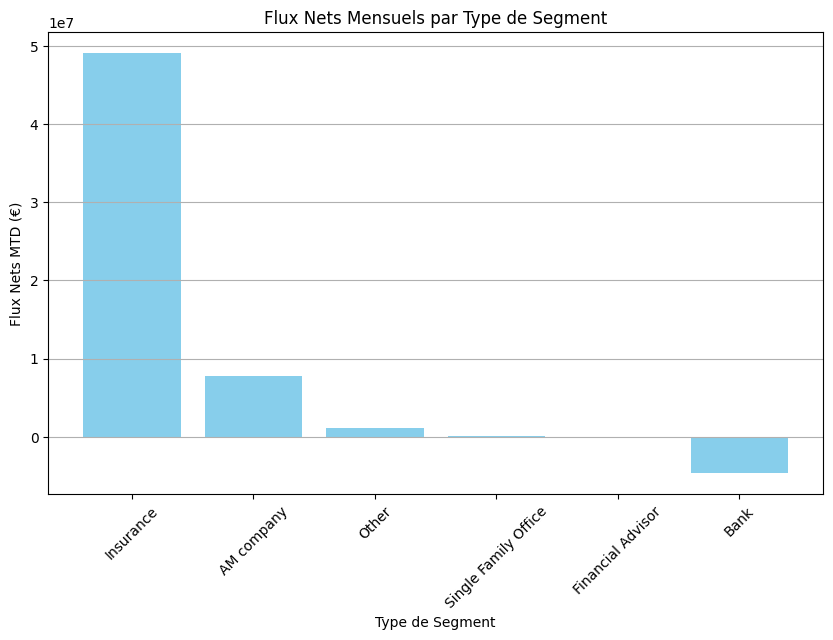

In [12]:
import matplotlib.pyplot as plt

# Visualiser les flux nets par type de segment
plt.figure(figsize=(10, 6))
plt.bar(segment_summary['Segment_Type'], segment_summary['Net Inflows MTD (€)'], color='skyblue')
plt.title('Flux Nets Mensuels par Type de Segment')
plt.xlabel('Type de Segment')
plt.ylabel('Flux Nets MTD (€)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [13]:
segmentation_clients

,Segment_Type,Share Type,Currency,Profile,Business Country (Business Relationship) (Business Relationship),Date,Year,Quarter,Semester,Net Inflows MTD (€),Net Inflows YTD (€),AUM (€)
1995,Insurance,A,EUR,A - EUR,FRANCE,2022-08-31 06:00:00,2022,2022Q3,2022-08,26285847,25382298,33885201.0
2000,Insurance,A,EUR,A - EUR,FRANCE,2023-01-31 05:00:00,2023,2023Q1,2023-01,16706218,16706218,54682389.0
364,AM company,I,EUR,I - EUR,WORLD,2020-10-31 05:00:00,2020,2020Q4,2020-10,15910596,14336147,16998142.0
1464,Bank,I,EUR,I - EUR,ITALY,2023-04-30 06:00:00,2023,2023Q2,2023-04,10674509,12320214,14386684.0
1437,Bank,I,EUR,I - EUR,AUSTRIA,2022-01-31 05:00:00,2022,2022Q1,2022-01,8387855,8387855,8277615.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2006,Insurance,A,EUR,A - EUR,FRANCE,2023-07-31 06:00:00,2023,2023Q3,2023-07,-4980202,18546264,57242774.0
1438,Bank,I,EUR,I - EUR,AUSTRIA,2022-02-28 05:00:00,2022,2022Q1,2022-02,-5607801,2780054,2488159.0
2186,Insurance,N,EUR,N - EUR,FRANCE,2021-01-31 05:00:00,2021,2021Q1,2021-01,-12422468,-12422468,0.0
366,AM company,I,EUR,I - EUR,WORLD,2020-12-31 05:00:00,2020,2020Q4,2020-12,-14680842,-219780,3351800.0


In [14]:
# tous les profils possibles en focntion du segment client profile net inflow MTD et AUM 

segmentation_clients['Profile_unique']=segmentation_clients['Segment_Type']+'-'+segmentation_clients['Profile']+'-'+segmentation_clients['Business Country (Business Relationship) (Business Relationship)']

In [15]:
segmentation_clients['Profile_Count'] = segmentation_clients.groupby('Profile_unique')['Profile_unique'].transform('count')
segmentation_clients.groupby('Profile_unique')[['Net Inflows MTD (€)', 'AUM (€)', 'Profile_Count']].sum().reset_index().sort_values(by='Net Inflows MTD (€)', ascending=False).sort_values(by='Profile_Count', ascending=False)


,Profile_unique,Net Inflows MTD (€),AUM (€),Profile_Count
65,Insurance-A - EUR-FRANCE,52339547,1.680008e+09,2401
4,AM company-A - EUR-WORLD,5104,2.413150e+07,2401
72,Other-A - EUR-UNKNOWN,0,-2.611854e+07,2401
74,Other-CR - EUR-UNKNOWN,0,1.623840e+05,2401
67,Insurance-CR - EUR-LUXEMBOURG,-43,4.212741e+06,2401
...,...,...,...,...
6,AM company-CR - EUR-LUXEMBOURG,-3041,8.770000e+03,16
19,Bank-A - CHF-LUXEMBOURG,0,0.000000e+00,16
73,Other-B - EUR-UNKNOWN,0,-3.000000e+00,9
56,Bank-O - EUR-LUXEMBOURG,116098,3.464300e+05,9


In [16]:
segmentation_clients.columns

Index(['Segment_Type', 'Share Type', 'Currency', 'Profile',
       'Business Country (Business Relationship) (Business Relationship)',
       'Date', 'Year', 'Quarter', 'Semester', 'Net Inflows MTD (€)',
       'Net Inflows YTD (€)', 'AUM (€)', 'Profile_unique', 'Profile_Count'],
      dtype='object')

In [17]:
# Assurer que les dates sont au bon format
segmentation_clients['Date'] = pd.to_datetime(segmentation_clients['Date'])

# Trier les données pour le calcul des variations
segmentation_clients = segmentation_clients.sort_values(by=['Segment_Type', 'Date'])

# Calculer la variation d'AUM en pourcentage par client et typologie
segmentation_clients['AUM_Change'] = segmentation_clients.groupby('Segment_Type')['AUM (€)'].pct_change()

# Créer une variable pour détecter les baisses d'AUM supérieures à 10%
segmentation_clients['AUM_Drop'] = segmentation_clients['AUM_Change'] <= -0.10

# Vérification
print(segmentation_clients[['Segment_Type', 'Date', 'AUM (€)', 'AUM_Change', 'AUM_Drop']].head())

    Segment_Type                Date    AUM (€)     AUM_Change  AUM_Drop
4     AM company 2020-09-30 06:00:00   647253.0            NaN     False
0     AM company 2020-09-30 06:00:00      102.0      -0.999842      True
546   AM company 2020-09-30 06:00:00    17104.0     166.686275     False
412   AM company 2020-09-30 06:00:00       10.0      -0.999415      True
363   AM company 2020-09-30 06:00:00  1192293.0  119228.300000     False


In [18]:
# Exemple simple : Marquer des baisses de flux nets (crises internes)
segmentation_clients['Crisis_Period'] = segmentation_clients['Net Inflows MTD (€)'] < 0

# Vérification
segmentation_clients[['Segment_Type', 'Date', 'Net Inflows MTD (€)', 'Crisis_Period']]

,Segment_Type,Date,Net Inflows MTD (€),Crisis_Period
4,AM company,2020-09-30 06:00:00,1838,False
0,AM company,2020-09-30 06:00:00,0,False
546,AM company,2020-09-30 06:00:00,0,False
412,AM company,2020-09-30 06:00:00,0,False
363,AM company,2020-09-30 06:00:00,0,False
...,...,...,...,...
2471,Single Family Office,2024-05-31 06:00:00,0,False
2472,Single Family Office,2024-06-30 06:00:00,0,False
2473,Single Family Office,2024-07-31 06:00:00,0,False
2474,Single Family Office,2024-08-31 06:00:00,0,False


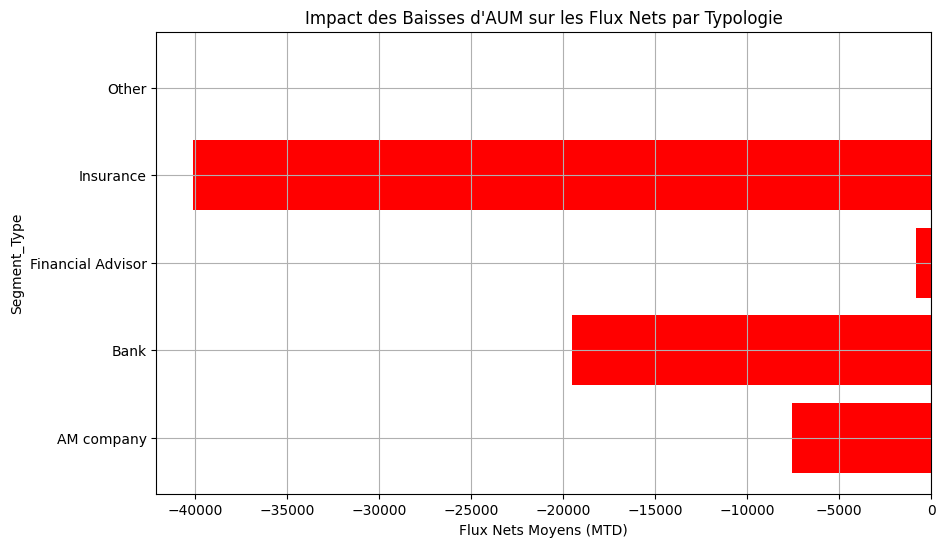

In [19]:
# Filtrer les données où AUM_Drop est True
aum_drops = segmentation_clients[segmentation_clients['AUM_Drop'] == True]

# Calculer les flux nets moyens par Segment_Type
behavior_aum = aum_drops.groupby('Segment_Type')['Net Inflows MTD (€)'].mean().reset_index()

# Visualisation
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(behavior_aum['Segment_Type'], behavior_aum['Net Inflows MTD (€)'], color='red')
plt.title('Impact des Baisses d\'AUM sur les Flux Nets par Typologie')
plt.xlabel('Flux Nets Moyens (MTD)')
plt.ylabel('Segment_Type')
plt.grid()
plt.show()

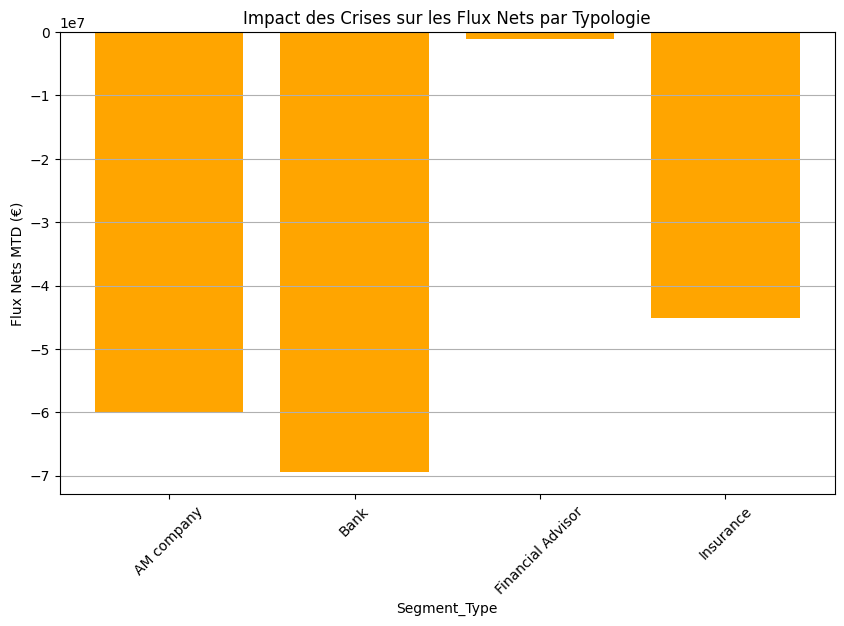

In [20]:
# Filtrer les périodes de crise
crisis_behavior = segmentation_clients[segmentation_clients['Crisis_Period'] == True]

# Calculer les flux nets moyens par typologie pendant les crises
crisis_analysis = crisis_behavior.groupby('Segment_Type')['Net Inflows MTD (€)'].sum().reset_index()

# Visualisation
plt.figure(figsize=(10, 6))
plt.bar(crisis_analysis['Segment_Type'], crisis_analysis['Net Inflows MTD (€)'], color='orange')
plt.title('Impact des Crises sur les Flux Nets par Typologie')
plt.xlabel('Segment_Type')
plt.ylabel('Flux Nets MTD (€)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [21]:
# Filtrer les lignes où SECURITY_NAME contient "EdR Fund Euro High Yield"
frais_yield = frais[frais['SECURITY_NAME'].str.contains("EdR Fund Euro High Yield", case=False, na=False)]

# Afficher les premières lignes pour vérification
frais_yield

,PORTFOLIO_IK,SECURITY_ISIN,SECURITY_NAME,DATE_FRAIS,TYPE_FRAIS,MONTANT_FRAIS,DEVISE_FRAIS
35345,18502,LU1160362742,EdR Fund Euro High Yield I - EUR,2020-09-30 00:00:00.000,FRAIS_FIXE,-176.28,EUR
35346,18502,LU1160362742,EdR Fund Euro High Yield I - EUR,2020-09-30 00:00:00.000,FRAIS_VARIABLE,-1801.54,EUR
35347,18502,LU1160362742,EdR Fund Euro High Yield I - EUR,2020-09-30 00:00:00.000,FRAIS_GLOBAL,-52.00,EUR
35348,18502,LU1160362742,EdR Fund Euro High Yield I - EUR,2020-10-01 00:00:00.000,FRAIS_GLOBAL,-83.55,EUR
35349,18502,LU1160362742,EdR Fund Euro High Yield I - EUR,2020-10-01 00:00:00.000,FRAIS_FIXE,-176.79,EUR
...,...,...,...,...,...,...,...
101008,45519,LU1781816373,EdR Fund Euro High Yield CR - EUR,2024-09-26 00:00:00.000,FRAIS_GLOBAL,-5.02,EUR
101009,45519,LU1781816373,EdR Fund Euro High Yield CR - EUR,2024-09-27 00:00:00.000,FRAIS_FIXE,-22.21,EUR
101010,45519,LU1781816373,EdR Fund Euro High Yield CR - EUR,2024-09-27 00:00:00.000,FRAIS_GLOBAL,-4.56,EUR
101011,45519,LU1781816373,EdR Fund Euro High Yield CR - EUR,2024-09-30 00:00:00.000,FRAIS_GLOBAL,-14.09,EUR


In [22]:
frais_yield['Share Type'] = frais_yield['SECURITY_NAME'].str.extract(r'(\w) -')


/var/folders/bv/5rwcdyf13z576lffnd4q0ym40000gn/T/ipykernel_38447/1526208100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frais_yield['Share Type'] = frais_yield['SECURITY_NAME'].str.extract(r'(\w) -')


In [23]:
def get_share_type(x):
    split_result = x.split(' - ')
    if len(split_result) >= 2:
        return split_result[-2]
    else:
        return None

frais_yield['Share_fail'] = frais_yield['SECURITY_NAME'].apply(get_share_type)
frais_yield['Share_Type']=frais_yield['Share_fail'].str.rsplit(' ', n=1).str[1]

/var/folders/bv/5rwcdyf13z576lffnd4q0ym40000gn/T/ipykernel_38447/1544924689.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frais_yield['Share_fail'] = frais_yield['SECURITY_NAME'].apply(get_share_type)
/var/folders/bv/5rwcdyf13z576lffnd4q0ym40000gn/T/ipykernel_38447/1544924689.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frais_yield['Share_Type']=frais_yield['Share_fail'].str.rsplit(' ', n=1).str[1]


In [24]:
import pandas as pd

# Assurer que DATE_FRAIS est en format datetime
frais_yield['DATE_FRAIS'] = pd.to_datetime(frais_yield['DATE_FRAIS'])

# Extraire le dernier jour du mois pour chaque date
frais_yield['Last_Day_Month'] = frais_yield['DATE_FRAIS'] + pd.offsets.MonthEnd(0)

# Grouper par le dernier jour du mois et le TYPE_FRAIS pour calculer les montants totaux
frais_pivot = (
    frais_yield.groupby(['Last_Day_Month', 'TYPE_FRAIS','Share_Type'])['MONTANT_FRAIS']
    .sum()
    .reset_index()
)

# Transformer TYPE_FRAIS en colonnes avec pivot_table
type_frais = frais_pivot.pivot_table(
    index=['Last_Day_Month','Share_Type'],      # Index = derniers jours du mois
    columns='TYPE_FRAIS',        # Colonnes = Types de frais
    values='MONTANT_FRAIS',      # Valeurs = Montant total des frais
    fill_value=0                 # Remplacer les NaN par 0
).reset_index()

# Renommer la colonne "Last_Day_Month" en "Date"
type_frais.rename(columns={'Last_Day_Month': 'Date'}, inplace=True)

# Afficher la nouvelle dataframe


/var/folders/bv/5rwcdyf13z576lffnd4q0ym40000gn/T/ipykernel_38447/172672321.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frais_yield['DATE_FRAIS'] = pd.to_datetime(frais_yield['DATE_FRAIS'])
/var/folders/bv/5rwcdyf13z576lffnd4q0ym40000gn/T/ipykernel_38447/172672321.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frais_yield['Last_Day_Month'] = frais_yield['DATE_FRAIS'] + pd.offsets.MonthEnd(0)


In [25]:
type_frais.to_csv('processed/type_frais.csv', index=False)


In [26]:
perf_fond

,PORTFOLIO_IK_PASSIF,SECURITY_ID,SECURITY_ISIN,SECURITY_NAME,PERFORMANCE_START_DATE,ANALYSIS_DATE_FULL,TWR_NET_CUMULATED,TWR_1DC,TWR_1WC,TWR_1MC,...,TWR_3YR,TWR_5YR,TWR_10YR,TWR_1YAnn,TWR_2YAnn,TWR_3YAnn,TWR_5YAnn,TWR_10YAnn,TWR_BRUT_CUMULATED,REPORTING_CURRENCY
0,188,STHOPME FP,FR0010505578,EdR SICAV - Euro Sustainable Equity A - EUR,1984-07-05 00:00:00.000,2024-09-30 00:00:00.000,17.927670,-0.502563,0.270115,0.669503,...,16.006172,39.203600,92.643768,17.886389,17.875147,5.068876,6.831332,6.770705,30.522838,EUR
1,188,STHOPME FP,FR0010505578,EdR SICAV - Euro Sustainable Equity A - EUR,1984-07-05 00:00:00.000,2024-09-27 00:00:00.000,18.018223,-0.436987,2.007895,1.177986,...,13.941592,40.611971,93.422332,19.728028,18.570408,4.442403,7.046396,6.811816,30.671755,EUR
2,188,STHOPME FP,FR0010505578,EdR SICAV - Euro Sustainable Equity A - EUR,1984-07-05 00:00:00.000,2024-09-26 00:00:00.000,18.097306,1.218895,2.455613,1.622061,...,13.733971,41.723201,94.271272,19.952784,18.159042,4.370837,7.214873,6.860493,30.804608,EUR
3,188,STHOPME FP,FR0010505578,EdR SICAV - Euro Sustainable Equity A - EUR,1984-07-05 00:00:00.000,2024-09-25 00:00:00.000,17.879375,0.221647,1.221825,0.398312,...,12.364368,40.684971,92.299451,17.705270,17.147817,3.955013,7.057497,6.751622,30.431886,EUR
4,188,STHOPME FP,FR0010505578,EdR SICAV - Euro Sustainable Equity A - EUR,1984-07-05 00:00:00.000,2024-09-24 00:00:00.000,17.839834,0.477712,0.008461,0.176274,...,12.115866,39.456360,90.102927,16.237306,17.043862,3.882068,6.870057,6.629155,30.362838,EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49447,85000,EDSUAUS FP,FR001400MEF5,EdR SICAV - Euro Sustainable Equity A - USD,2024-05-29 00:00:00.000,2024-06-03 00:00:00.000,1.000200,0.482218,1.574083,0.482218,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000545,USD
49448,85000,EDSUAUS FP,FR001400MEF5,EdR SICAV - Euro Sustainable Equity A - USD,2024-05-29 00:00:00.000,2024-05-31 00:00:00.000,0.995400,0.302297,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.995571,USD
49449,85000,EDSUAUS FP,FR001400MEF5,EdR SICAV - Euro Sustainable Equity A - USD,2024-05-29 00:00:00.000,2024-05-30 00:00:00.000,0.992400,0.781964,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.992513,USD
49450,85000,EDSUAUS FP,FR001400MEF5,EdR SICAV - Euro Sustainable Equity A - USD,2024-05-29 00:00:00.000,2024-05-29 00:00:00.000,0.984700,-1.530000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.984756,USD


In [27]:
# Filtrer les lignes où SECURITY_NAME contient "EdR Fund Euro High Yield"
perf_yield= perf_fond[perf_fond['SECURITY_NAME'].str.contains("EdR Fund Euro High Yield", case=False, na=False)]

perf_yield['Share Type'] = perf_yield['SECURITY_NAME'].str.extract(r'(\w) -')
perf_yield['Share_fail'] = perf_yield['SECURITY_NAME'].apply(get_share_type)
perf_yield['Share_Type']=perf_yield['Share_fail'].str.rsplit(' ', n=1).str[1]

/var/folders/bv/5rwcdyf13z576lffnd4q0ym40000gn/T/ipykernel_38447/1898073468.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_yield['Share Type'] = perf_yield['SECURITY_NAME'].str.extract(r'(\w) -')
/var/folders/bv/5rwcdyf13z576lffnd4q0ym40000gn/T/ipykernel_38447/1898073468.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_yield['Share_fail'] = perf_yield['SECURITY_NAME'].apply(get_share_type)
/var/folders/bv/5rwcdyf13z576lffnd4q0ym40000gn/T/ipykernel_38447/1898073468.py:6: SettingWithCopyWarn

In [28]:
segmentation_clients['Date_year_month'] = segmentation_clients['Date'].dt.to_period('M')
type_frais['Date_year_month'] = type_frais['Date'].dt.to_period('M')
perf_yield['ANALYSIS_DATE_FULL'] = pd.to_datetime(perf_yield['ANALYSIS_DATE_FULL'])
perf_yield['Date_year_month'] = perf_yield['ANALYSIS_DATE_FULL'].dt.to_period('M')


/var/folders/bv/5rwcdyf13z576lffnd4q0ym40000gn/T/ipykernel_38447/2243950629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_yield['ANALYSIS_DATE_FULL'] = pd.to_datetime(perf_yield['ANALYSIS_DATE_FULL'])
/var/folders/bv/5rwcdyf13z576lffnd4q0ym40000gn/T/ipykernel_38447/2243950629.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_yield['Date_year_month'] = perf_yield['ANALYSIS_DATE_FULL'].dt.to_period('M')


In [29]:
# Étape 1 : Fusionner type_frais avec segmentation_clients
combined_df = pd.merge(
    segmentation_clients,
    type_frais,
    left_on=['Date_year_month', 'Share Type'],
    right_on=['Date_year_month', 'Share_Type'],
    how='left'
)

# Étape 2 : Fusionner avec les performances du fonds
# Assurez-vous que 'Date' et 'Share Type' existent dans perf_fond
combined_df = pd.merge(
    combined_df,
    perf_yield[['Date_year_month', 'Share Type', 'TWR_NET_CUMULATED']],  # Exemple de performance cumulée
    on=['Date_year_month', 'Share Type'],
    how='left'
)

# Afficher un aperçu des données fusionnées
print(combined_df.head())

  Segment_Type Share Type Currency  Profile  \
0   AM company          A      EUR  A - EUR   
1   AM company          A      EUR  A - EUR   
2   AM company          A      EUR  A - EUR   
3   AM company          A      CHF  A - CHF   
4   AM company          A      CHF  A - CHF   

  Business Country (Business Relationship) (Business Relationship)  \
0                                             FRANCE                 
1                                             FRANCE                 
2                                             FRANCE                 
3                                         LUXEMBOURG                 
4                                         LUXEMBOURG                 

               Date_x  Year Quarter Semester  Net Inflows MTD (€)  ...  \
0 2020-09-30 06:00:00  2020  2020Q3  2020-09                 1838  ...   
1 2020-09-30 06:00:00  2020  2020Q3  2020-09                 1838  ...   
2 2020-09-30 06:00:00  2020  2020Q3  2020-09                 1838  ...   


In [30]:
# Créer une colonne pour le total des frais par ligne
combined_df['Total_Frais'] = combined_df[['FRAIS_ACQUIS', 'FRAIS_FIXE', 'FRAIS_GLOBAL', 'FRAIS_VARIABLE']].sum(axis=1)

# Calculer la proportion des frais par rapport à l'AUM
combined_df['Frais_AUM_Ratio'] = combined_df['Total_Frais'] / combined_df['AUM (€)']

# Vérifier les résultats
print(combined_df[['Date_year_month', 'Segment_Type', 'Total_Frais', 'AUM (€)', 'Frais_AUM_Ratio']].head())

  Date_year_month Segment_Type  Total_Frais   AUM (€)  Frais_AUM_Ratio
0         2020-09   AM company    -13580.53  647253.0        -0.020982
1         2020-09   AM company    -13580.53  647253.0        -0.020982
2         2020-09   AM company    -13580.53  647253.0        -0.020982
3         2020-09   AM company    -13580.53     102.0      -133.142451
4         2020-09   AM company    -13580.53     102.0      -133.142451


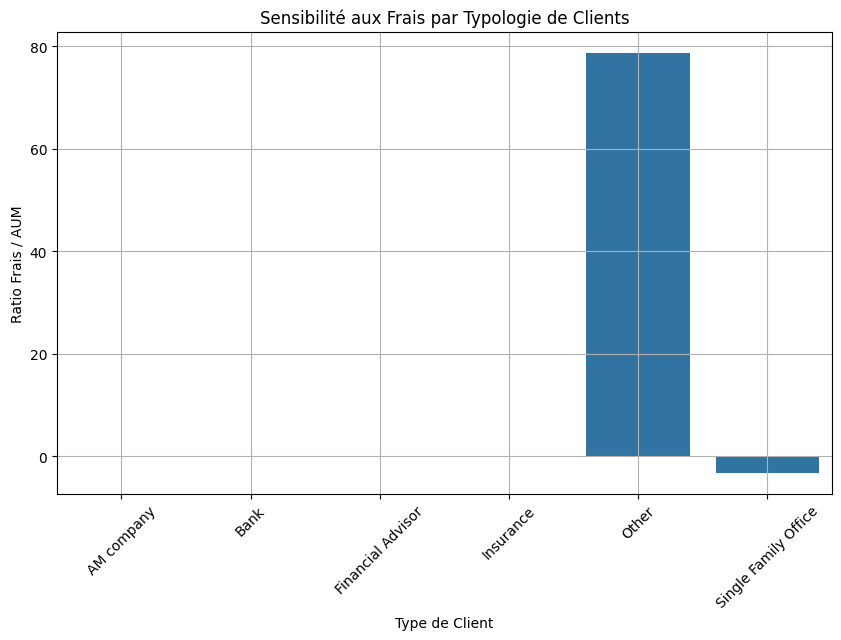

In [31]:
# Agréger les données par Segment_Type
fractions_by_client = combined_df.groupby('Segment_Type')['Frais_AUM_Ratio'].mean().reset_index()

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=fractions_by_client, x='Segment_Type', y='Frais_AUM_Ratio')
plt.title('Sensibilité aux Frais par Typologie de Clients')
plt.xlabel('Type de Client')
plt.ylabel('Ratio Frais / AUM')
plt.xticks(rotation=45)
plt.grid()
plt.show()

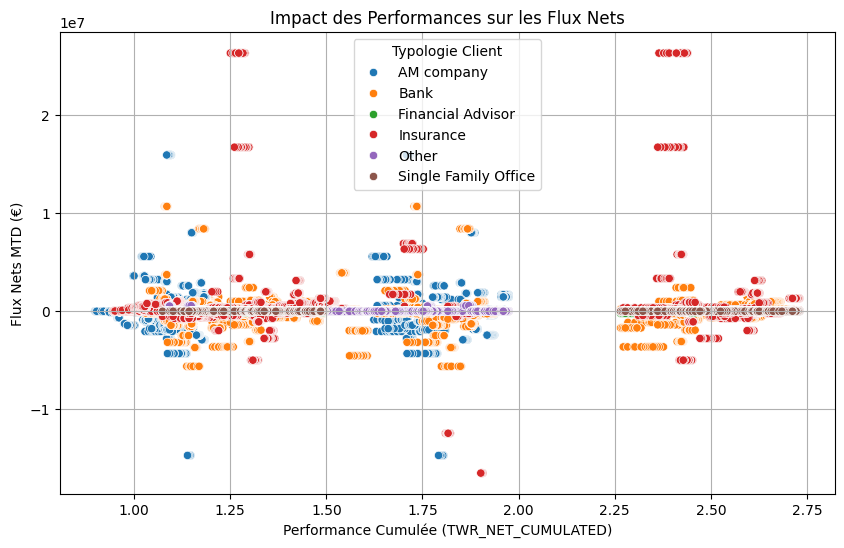

In [32]:
# Créer un scatter plot pour montrer la relation
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=combined_df,
    x='TWR_NET_CUMULATED',
    y='Net Inflows MTD (€)',
    hue='Segment_Type'
)
plt.title('Impact des Performances sur les Flux Nets')
plt.xlabel('Performance Cumulée (TWR_NET_CUMULATED)')
plt.ylabel('Flux Nets MTD (€)')
plt.legend(title='Typologie Client')
plt.grid()
plt.show()

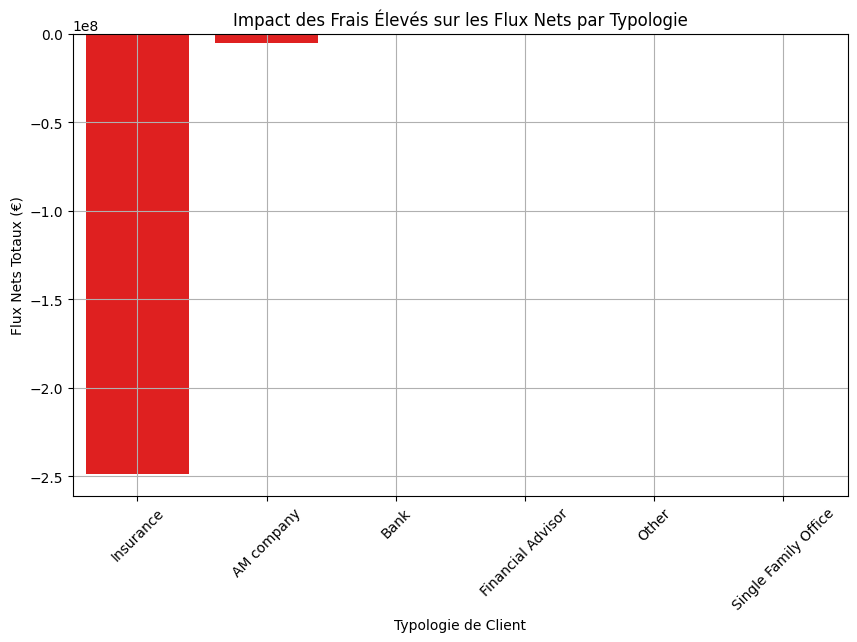

In [33]:
# Filtrer les périodes de frais élevés
high_fees_clients = combined_df[combined_df['Frais_AUM_Ratio'] > 0.02]  # Exemple : frais > 2% de l'AUM

# Agréger les flux nets par typologie client pendant ces périodes
high_fee_analysis = (
    high_fees_clients.groupby('Segment_Type')['Net Inflows MTD (€)']
    .sum()
    .reset_index()
    .sort_values(by='Net Inflows MTD (€)', ascending=True)
)

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=high_fee_analysis, x='Segment_Type', y='Net Inflows MTD (€)', color='red')
plt.title('Impact des Frais Élevés sur les Flux Nets par Typologie')
plt.xlabel('Typologie de Client')
plt.ylabel('Flux Nets Totaux (€)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [34]:
# Créer la métrique "Frais en pourcentage de l'AUM"
combined_df['Frais_AUM_Ratio'] = combined_df[['FRAIS_ACQUIS', 'FRAIS_FIXE', 'FRAIS_GLOBAL', 'FRAIS_VARIABLE']].sum(axis=1) / combined_df['AUM (€)']

# Calcul des variations de performance sur 3, 6 et 12 mois
combined_df = combined_df.sort_values(by=['Segment_Type', 'Share Type', 'Date_year_month'])

combined_df['Perf_3M_Change'] = combined_df.groupby(['Segment_Type', 'Share Type'])['TWR_NET_CUMULATED'].diff(periods=3)
combined_df['Perf_6M_Change'] = combined_df.groupby(['Segment_Type', 'Share Type'])['TWR_NET_CUMULATED'].diff(periods=6)
combined_df['Perf_12M_Change'] = combined_df.groupby(['Segment_Type', 'Share Type'])['TWR_NET_CUMULATED'].diff(periods=12)

# Identifier les périodes de frais élevés (>2% de l'AUM)
combined_df['High_Fees'] = combined_df['Frais_AUM_Ratio'] > 0.02

# Identifier les baisses de performance significatives (ex : -10% sur 6 mois)
combined_df['Perf_Drop_6M'] = combined_df['Perf_6M_Change'] <= -1

# Vérification des nouvelles colonnes
print(combined_df[['Date_year_month', 'Segment_Type', 'Frais_AUM_Ratio', 'Perf_6M_Change', 'High_Fees', 'Perf_Drop_6M']].head())

  Date_year_month Segment_Type  Frais_AUM_Ratio  Perf_6M_Change  High_Fees  \
0         2020-09   AM company        -0.020982             NaN      False   
1         2020-09   AM company        -0.020982             NaN      False   
2         2020-09   AM company        -0.020982             NaN      False   
3         2020-09   AM company      -133.142451             NaN      False   
4         2020-09   AM company      -133.142451             NaN      False   

   Perf_Drop_6M  
0         False  
1         False  
2         False  
3         False  
4         False  


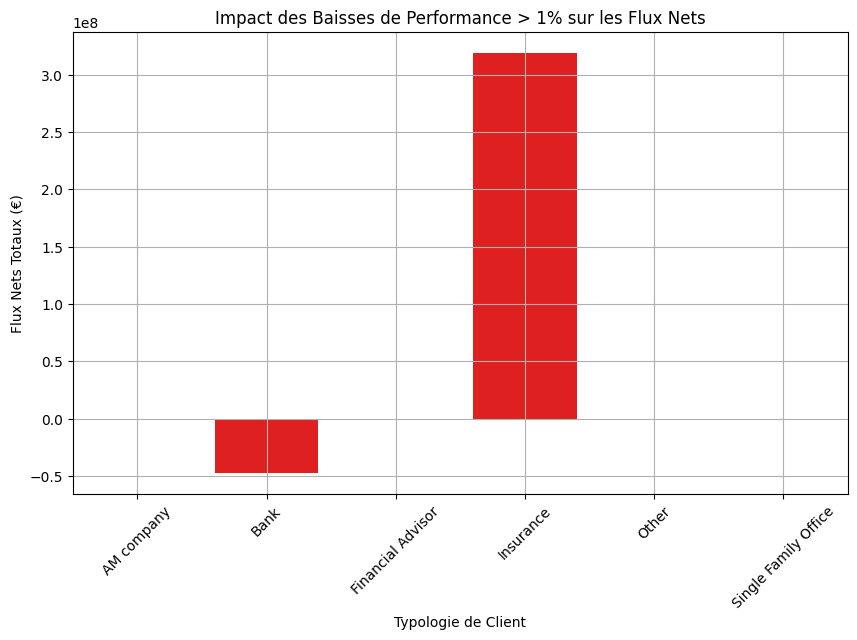

In [35]:
# Filtrer les baisses de performance de -1% sur 6 mois
perf_drop_analysis = combined_df[combined_df['Perf_Drop_6M']].groupby('Segment_Type')['Net Inflows MTD (€)'].sum().reset_index()

# Visualiser les résultats
plt.figure(figsize=(10, 6))
sns.barplot(data=perf_drop_analysis, x='Segment_Type', y='Net Inflows MTD (€)', color='red')
plt.title('Impact des Baisses de Performance > 1% sur les Flux Nets')
plt.xlabel('Typologie de Client')
plt.ylabel('Flux Nets Totaux (€)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

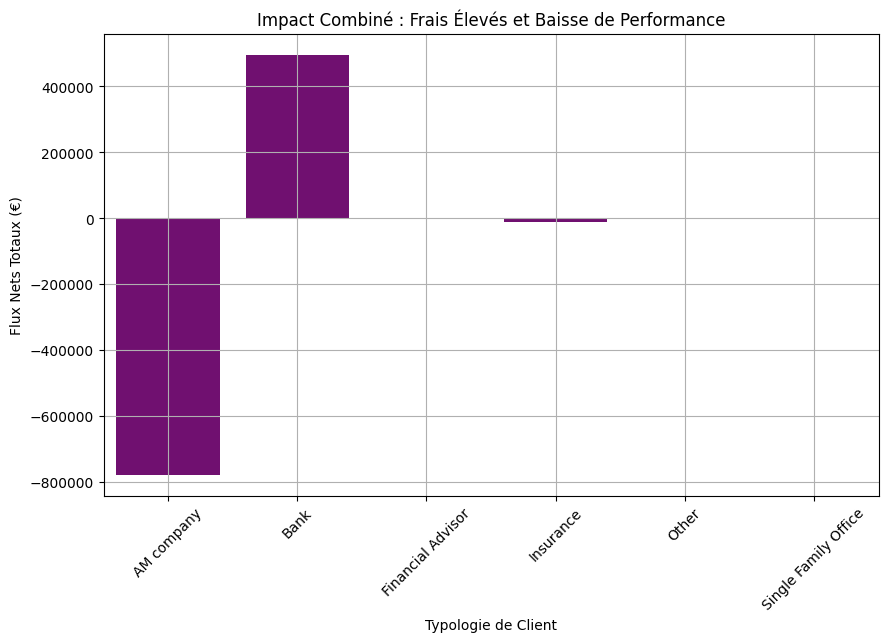

In [36]:
# Filtrer les clients avec frais élevés ET baisse de performance
combined_filter = combined_df[(combined_df['High_Fees']) & (combined_df['Perf_Drop_6M'])]

# Agréger par typologie client
combined_analysis = combined_filter.groupby('Segment_Type')['Net Inflows MTD (€)'].sum().reset_index()

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_analysis, x='Segment_Type', y='Net Inflows MTD (€)', color='purple')
plt.title('Impact Combiné : Frais Élevés et Baisse de Performance')
plt.xlabel('Typologie de Client')
plt.ylabel('Flux Nets Totaux (€)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [37]:
high_fee_analysis

,Segment_Type,Net Inflows MTD (€)
3,Insurance,-248524080
0,AM company,-5196120
1,Bank,-663272
2,Financial Advisor,0
4,Other,0
5,Single Family Office,0


In [38]:
perf_drop_analysis

,Segment_Type,Net Inflows MTD (€)
0,AM company,-879084
1,Bank,-47058738
2,Financial Advisor,130428
3,Insurance,318978192
4,Other,0
5,Single Family Office,239220


In [39]:
combined_analysis

,Segment_Type,Net Inflows MTD (€)
0,AM company,-779418
1,Bank,495690
2,Financial Advisor,0
3,Insurance,-11208
4,Other,0
5,Single Family Office,0


In [40]:
# Agrégation par typologie client et période (Année / Semestre)
agg_data = combined_df.groupby(['Segment_Type', 'Year', 'Semester']).agg({
    'Net Inflows MTD (€)': 'sum',       # Flux nets totaux
    'Frais_AUM_Ratio': 'mean',          # Moyenne des frais en % de l'AUM
    'TWR_NET_CUMULATED': 'mean',        # Moyenne de la performance cumulée
}).reset_index()

# Calcul de la variation de performance (sur 6 mois)
agg_data['Perf_Change_6M'] = agg_data.groupby('Segment_Type')['TWR_NET_CUMULATED'].diff()

# Vérification des résultats
print(agg_data.head())

  Segment_Type  Year Semester  Net Inflows MTD (€)  Frais_AUM_Ratio  \
0   AM company  2020  2020-09               -20925       -27.862229   
1   AM company  2020  2020-10            577791852      -226.842883   
2   AM company  2020  2020-11           -169556269      -488.927114   
3   AM company  2020  2020-12           -562585460             -inf   
4   AM company  2021  2021-01            -15829861       -27.001016   

   TWR_NET_CUMULATED  Perf_Change_6M  
0           1.519838             NaN  
1           1.532965        0.013128  
2           1.571447        0.038481  
3           1.589443        0.017996  
4           1.570197       -0.019246  


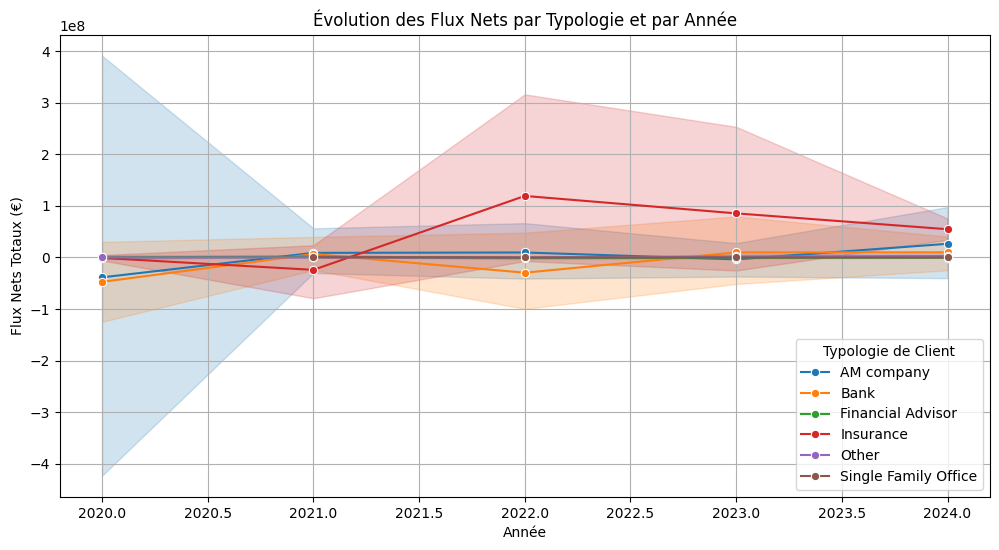

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=agg_data, x='Year', y='Net Inflows MTD (€)', hue='Segment_Type', marker='o')
plt.title('Évolution des Flux Nets par Typologie et par Année')
plt.xlabel('Année')
plt.ylabel('Flux Nets Totaux (€)')
plt.grid()
plt.legend(title='Typologie de Client')
plt.show()